In [1]:
# Packages for reading the edf file 
import mne
from pyedflib import highlevel


# regular
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import glob 


def plotstyle(size=20):
    plt.xlabel('xlabel',  fontsize = size)
    plt.ylabel('ylabel',  fontsize = size)

    plt.xticks(size=size)
    plt.yticks(size=size)

In [2]:
!ls files/S001

S001R01.edf       S001R04.edf.event S001R08.edf       S001R11.edf.event
S001R01.edf.event S001R05.edf       S001R08.edf.event S001R12.edf
S001R02.edf       S001R05.edf.event S001R09.edf       S001R12.edf.event
S001R02.edf.event S001R06.edf       S001R09.edf.event S001R13.edf
S001R03.edf       S001R06.edf.event S001R10.edf       S001R13.edf.event
S001R03.edf.event S001R07.edf       S001R10.edf.event S001R14.edf
S001R04.edf       S001R07.edf.event S001R11.edf       S001R14.edf.event


## Experiment Run Description : 

S00N is the N-th sample (volunteer),  R0M is the M-th experimental runs (1st-14th). 

The 14 experiment runs includes: 
two one-minute baseline runs (one with eyes open, one with eyes closed)
three two-minute runs of each of the four following tasks:


1. A target appears on either the left or the right side of the screen. The subject opens and closes the corresponding fist until the target disappears. Then the subject relaxes.


2. A target appears on either the left or the right side of the screen. The subject imagines opening and closing the corresponding fist until the target disappears. Then the subject relaxes.

3. A target appears on either the top or the bottom of the screen. The subject opens and closes either both fists (if the target is on top) or both feet (if the target is on the bottom) until the target disappears. Then the subject relaxes.

4. A target appears on either the top or the bottom of the screen. The subject imagines opening and closing either both fists (if the target is on top) or both feet (if the target is on the bottom) until the target disappears. Then the subject relaxes.


R1:  Baseline, eyes open (1 minutes)\\\
R2:  Baseline, eyes closed (1 minutes)\\\
--- 2 minutes --- \\\
R3:  Task 1 2 minutes (open and close left or right fist)  \\\
R4:  Task 2 (**imagine** opening and closing left or right fist) \\\
R5:  Task 3 (open and close both fists (top) or both feet (bottom) ) \\\
R6:  Task 4 (**imagine** opening and closing both fists or both feet) \\\
R7:  Task 1
R8:  Task 2
R9:  Task 3
R10: Task 4
R11: Task 1
R12: Task 2
R13: Task 3
R14: Task 4


In [3]:
S001 = glob.glob('files/S001/*.edf')
S001.sort()
signals, signal_headers, header = highlevel.read_edf(S001[0])

# labels are the nodes on the head
labels =[ i['label'].replace('.', '') for i in signal_headers ] 


biosemi_montage = mne.channels.make_standard_montage('biosemi64')
channels = biosemi_montage.ch_names
channels.sort()
d = {}
for i, col in enumerate(labels): 
    d[col] = channels[i] 

def edf_pd(filename): 
    signals, signal_headers, header = highlevel.read_edf(filename)
    df = pd.DataFrame( np.transpose(signals) , columns = labels)
    df = df.rename(columns=d)
    return df

# take the data of a few run 
r01 = edf_pd(S001[0])
r02 = edf_pd(S001[1])
r03 = edf_pd(S001[2])
r04 = edf_pd(S001[3])
r07 = edf_pd(S001[6])
r11 = edf_pd(S001[10])



## Data Description 
It's likely if you use mne all the way you can save a lot of efforts. 

mne: https://mne.tools/stable/index.html

The data contains 64 channels (head node position).  Signals are record every 1/160 second. 

"signals" contains all the signals of the channels.  

"signal_headers" contains the header of each channels.  It's standarized. 

"header" contains the description of the experiment: 

### header['annotations'] is an array of experiment states [time, duration , 'T0']: 

### 'T0' corresponds to rest

### 'T1' corresponds to onset of motion (real or imagined)  of the left fist (in runs 3, 4, 7, 8, 11, and 12)  both fists (in runs 5, 6, 9, 10, 13, and 14)

### 'T2' corresponds to onset of motion (real or imagined) of the right fist (in runs 3, 4, 7, 8, 11, and 12) both feet (in runs 5, 6, 9, 10, 13, and 14)





In [117]:
# Take a look of the header 
signals, signal_headers, header = highlevel.read_edf(S001[3])
header['annotations'][0:5]


[[0.0, 4.2, 'T0'],
 [4.2, 4.1, 'T2'],
 [8.3, 4.2, 'T0'],
 [12.5, 4.1, 'T1'],
 [16.6, 4.2, 'T0']]

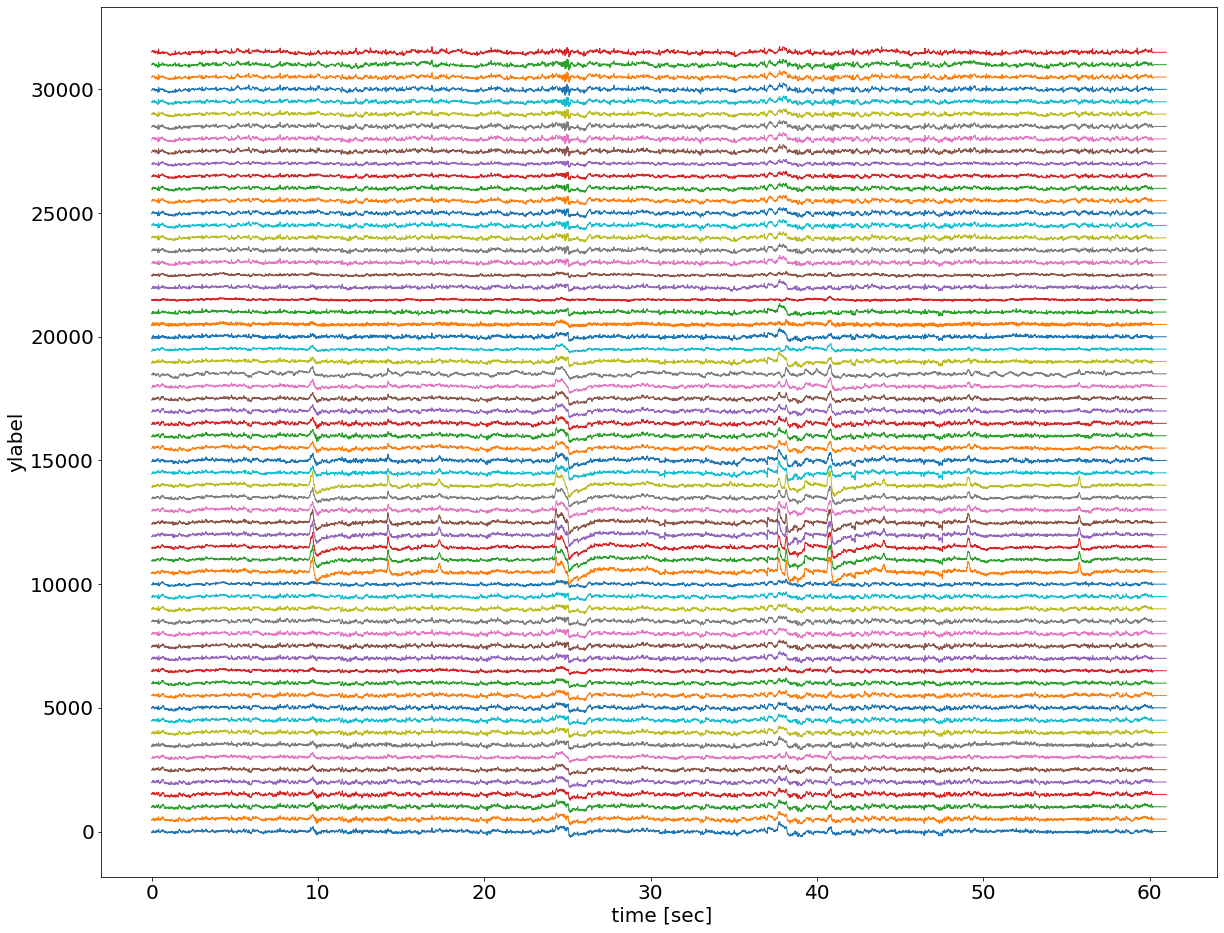

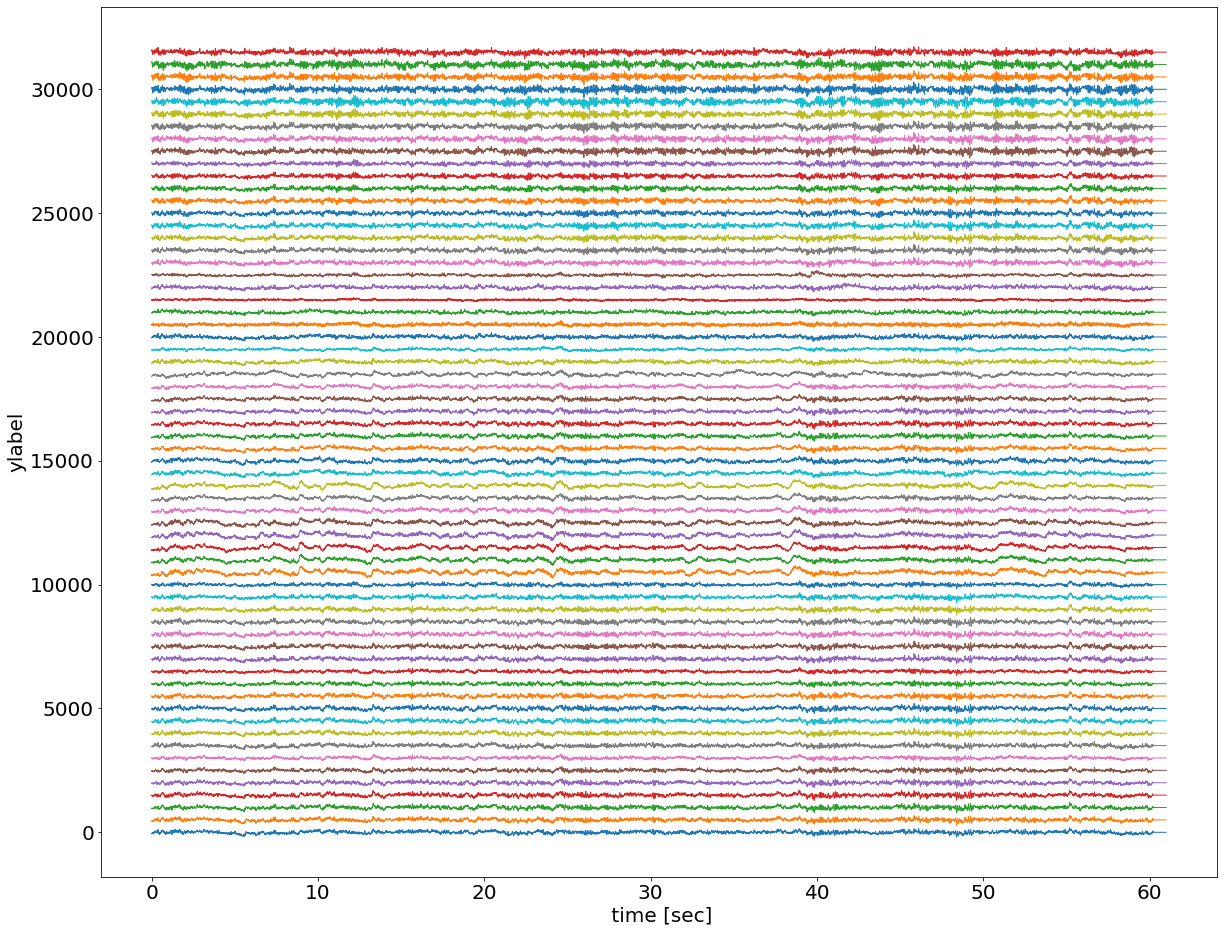

In [121]:
# Just a quick look of the data 
def mkplt(run):
    plt.figure(figsize = (20, 16))
    x = np.arange(0, len(run)/160, 1/160) 
    for i in range(len(labels)): 
        channel = run.columns[i]
        signal = run[channel] + 500*i 
        plt.plot(x, signal, lw = 1)


    plotstyle(20)
    plt.xlabel(' time [sec]') 
    plt.show()

# Take a look at run 1 (rest open eyes) and run 2 (rest close eyes)
# It's not super helpful 
mkplt(r01)
mkplt(r02)


In [124]:
## reference: https://mne.tools/stable/auto_examples/visualization/eeglab_head_sphere.html

def run2head(run):
    biosemi_montage = mne.channels.make_standard_montage('biosemi64')
    n_channels = len(biosemi_montage.ch_names)
    info = mne.create_info(ch_names=list(run.columns),#biosemi_montage.ch_names, 
                                sfreq=250.,
                                ch_types='eeg')

    rng = np.random.RandomState(0)
    data = np.transpose( run.values )
    evoked = mne.EvokedArray(data, info)
    evoked.set_montage(biosemi_montage)
    return evoked
    
    
def plthead(evoked, t_idx, smooth = 0, save = False):
    chs = ['Oz', 'Fpz', 'T7', 'T8']
    montage_head = evoked.get_montage()
    ch_pos = montage_head.get_positions()['ch_pos']
    pos = np.stack([ch_pos[ch] for ch in chs])
    radius = np.abs(pos[[2, 3], 0]).mean()
    x = pos[0, 0]
    y = pos[-1, 1]
    z = pos[:, -1].mean()
    
    fig, ax = plt.subplots(ncols=2, figsize=(15 , 8),
                           gridspec_kw=dict(top=0.9), sharex=True, sharey=True)
    
    signal = evoked.data[:, t_idx]
    if smooth > 0: 
         signal = np.mean( evoked.data[:, t_idx: t_idx+smooth ] , axis = 1 ) 

    mne.viz.plot_topomap(signal, evoked.info, axes=ax[0], show=False)
    mne.viz.plot_topomap(signal, evoked.info, axes=ax[1], show=False, sphere=(x, y, z, radius))
    

    # add titles
    ax[0].set_title('MNE', fontweight='bold')
    ax[1].set_title('EEGLAB', fontweight='bold')
    if save: 
        plt.savefig(f'plots/{t_idx}.png', dpi = 80)
        plt.close()
    plt.show()
    

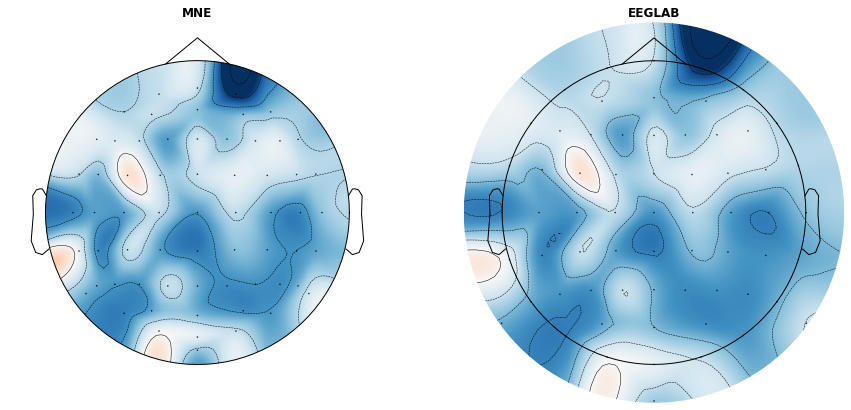

In [125]:
evoked = run2head(r01)
plthead(evoked, t_idx = 200 , smooth = 0 )

In [104]:
# make a bunch of plots 

evoked = run2head(r01)
for i in range(160):
    plthead(evoked, t_idx = i*10, smooth = 10 , save=True )


In [105]:
## Make a gif 

import imageio
filenames = glob.glob('plots/*png')
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f)))) 

images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('test.gif', images)